Authors: Anna Bernardi & Liam Kniberg

Date: 2025-10-21

# Introduction

Bioconcentration factor (BCF) is defined as a measure that reflects the ratio of a substance's concentration in an aquatic organism to its concentration in the surrounding water. So it quantifies the tendency of chemical compounds to accumulate in living organisms thus it's important for environmental risk assessment [1].

The aim of this project is to develop a computational model that can predict the log-transformed BCF (logBCF) of compounds from molecular descriptors, while accounting for potential correlations among descriptors and differences across chemical classes.

In practice, we'll explore the relationships between nine molecular descriptors and logBCF with two approaches:
1. Ridge regression to handle multicollinearity among descriptors;
2. Hierarchical modeling to account for class effects.

The dataset that was used for this project is the QSAR Bioconcentration available at: \
https://www.kaggle.com/datasets/rajgupta2019/qsar-bioconcentration-classes-dataset/data [2]

# Code requirements

In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


This Notebook should be run on Google Colab and using the following versions of the packages:



*   Python: 3.12
*   scikit-learn: 1.6
*   bambi: 0.15
*   arviz: 0.22
*   numpy: 2.0
*   matplotlib: 3.10
*   pandas: 2.2
*   scipy: 1.16
*   joblib: 1.5
*   seaborn: 0.13




In [ ]:
from google.colab import drive, files

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if 1:
    !pip install scikit-learn bambi arviz

# Sci-Kit Learn & model creation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import arviz as az
import bambi as bmb

import joblib

import scipy.stats as stats

# Data wrangling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Data

The train/test split already present in the dataset will be refered to as the **original split**, while the one obtained with the function `train_test_split` (random 80/20 split) will be refered to as the **new split**.

## Data Wrangling

In [ ]:
# Read in data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BERN02: Reproducible Project/Grisoni_et_al_2016_EnvInt88.csv")
df = df.set_index("CAS")
df_class = df["Class"]
df = df.rename(columns= {"B02[C-N]": "B02", "F04[C-O]":"F04", "N-072":"N_072"})
df_img = df.pop("SMILES")

In [ ]:
# Split data --- original split
train_df = df[df['Set'] == "Train"].copy()
test_df  = df[df['Set'] == "Test"].copy()

# Separate target
y_train = train_df.pop("logBCF")
y_test  = test_df.pop("logBCF")


numeric_features = train_df.drop(columns=["Set", "Class"]).columns

# Standardizing the predictors
scaler = StandardScaler()
x_train_scaled_orig = train_df.copy()
x_train_scaled_orig[numeric_features] = scaler.fit_transform(train_df[numeric_features])
x_train_scaled_orig = x_train_scaled_orig.drop(columns = "Set")


x_test_scaled_orig = test_df.copy()
x_test_scaled_orig[numeric_features] = scaler.transform(test_df[numeric_features])
x_test_scaled_orig = x_test_scaled_orig.drop(columns = "Set")

# Combine scaled predictors with 'Class' and target for Bambi
data_train = pd.concat([x_train_scaled_orig, y_train], axis=1)
data_test  = pd.concat([x_test_scaled_orig, y_test], axis=1)

print(data_train.head())

               nHM    piPC09       PCD      X2Av     MLOGP      ON1V  \
CAS                                                                    
100-02-7 -0.876781 -1.126749 -0.051240 -0.642702 -1.147527 -0.934861   
100-17-4 -0.876781 -1.126749 -0.071297 -0.642702 -0.928712 -0.743061   
100-18-5 -0.876781 -1.126749 -0.342061  0.096284  0.596743  0.671465   
100-25-4 -0.876781 -1.126749  0.149326 -0.709882 -0.809927 -0.850949   
100-40-3 -0.876781 -1.126749 -1.023986  0.096284 -0.334785 -0.227598   

             N_072       B02       F04  Class  logBCF  
CAS                                                    
100-02-7 -0.369751  1.180442  0.311216      1    0.74  
100-17-4 -0.369751  1.180442  0.311216      1    0.93  
100-18-5 -0.369751 -0.847141 -0.802449      3    3.24  
100-25-4 -0.369751  1.180442  0.979414      3   -0.40  
100-40-3 -0.369751 -0.847141 -0.802449      1    2.24  


In [ ]:
# Split data --- new split 20/80

df_new = df.drop(columns="Set").copy()

X = df_new.drop(columns="logBCF")
y = df_new["logBCF"]

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(
    X, y, test_size=0.2, random_state=25, shuffle=True
)

numeric_features_new = x_train_new.drop(columns="Class").columns

# Standardizing the predictors
scaler_new = StandardScaler()
x_train_scaled_new = x_train_new.copy()
x_train_scaled_new[numeric_features_new] = scaler_new.fit_transform(x_train_new[numeric_features_new])

x_test_scaled_new = x_test_new.copy()
x_test_scaled_new[numeric_features_new] = scaler_new.transform(x_test_new[numeric_features_new])

#Combine scaled data with target for Bambi
data_train_new = pd.concat([x_train_scaled_new, y_train_new], axis=1)
data_test_new  = pd.concat([x_test_scaled_new, y_test_new], axis=1)

print(data_train_new.head())


                 nHM    piPC09       PCD      X2Av     MLOGP      ON1V  \
CAS                                                                      
779-02-2   -0.890271  1.454448  2.041433 -0.494784  0.897974  0.210423   
1563-66-2  -0.890271  0.547663 -0.193504 -0.367802 -1.069774  0.357458   
38380-08-4  2.105077  1.068311  0.764327 -0.177327  2.079879 -0.365463   
120-83-2    0.108179 -1.158162 -0.327394 -0.240819 -0.271359 -1.063878   
2136-99-4   3.103527  1.118168  0.857020 -0.177327  2.369069 -0.389969   

               N_072       B02       F04  Class  logBCF  
CAS                                                      
779-02-2   -0.361746 -0.871715 -0.819348      3    2.72  
1563-66-2   1.650467 -0.871715  0.776532      1    1.08  
38380-08-4 -0.361746 -0.871715 -0.819348      2    5.88  
120-83-2   -0.361746 -0.871715 -0.591365      1    1.71  
2136-99-4  -0.361746 -0.871715 -0.819348      2    5.82  


## Data Visualization and description


#### Description
The dataframe contains the following informations:
1. Molecular Descriptors [3]:
* nHM: number of hydrogen bond donors in the molecule;
* piPC09: Polarizability Connectivity Index, topological descriptor related to polarizability and connectivity;
* PCD: Path Count Descriptor, topological descriptor related to molecular branching;
* X2Av: Average valence connectivity index, descriptor related to the connectivity of a molecule that accounts for the presence of heteroatoms and unsaturated bonds;
* MLOGP: $K_{OW}$ (octanol/water partition coefficient) predicted by the Moriguchi model;
* ON1V: valence connectivity index of nitrogen and oxigen in the molecule;
* N-072: count of the nitrogen atoms in a specific fragment of the molecule;
* B02[C-N]: number of C-N bonds that are two bonds apart (amines or amides)
* F04[C-O]: number of C-O bonds that are four bonds apart (alcohols, ethers, or carbonyl).
2. Dependent Variables:
* Class: bioaccumulation class of a compound (i.e. low, medium, high) based on BCF thresholds;
* logBCF: logarithm of the bioconcentration factor.

#### Overview of the dataset

In [ ]:
df.describe()

,nHM,piPC09,PCD,X2Av,MLOGP,ON1V,N_072,B02,F04,Class,logBCF
count,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000
mean,1.754814,3.467616,1.550822,0.236881,3.201746,1.510295,0.186136,0.423620,3.585366,1.736842,2.062773
std,1.985866,2.983778,0.958708,0.149319,1.595702,0.834753,0.501937,0.494449,4.430421,0.921782,1.351290
min,0.000000,0.000000,0.000000,0.090000,-1.960000,0.080000,0.000000,0.000000,0.000000,1.000000,-1.700000
25%,0.000000,0.000000,1.210000,0.170000,2.190000,0.910000,0.000000,0.000000,0.000000,1.000000,0.985000
50%,1.000000,4.263000,1.400000,0.200000,3.130000,1.270000,0.000000,0.000000,2.000000,1.000000,2.030000
75%,3.000000,6.250000,2.285000,0.240000,4.235000,2.020000,0.000000,1.000000,6.000000,3.000000,2.950000
max,12.000000,9.316000,5.900000,2.230000,8.320000,7.190000,3.000000,1.000000,25.000000,3.000000,6.060000


array([[<Axes: title={'center': 'nHM'}>,
        <Axes: title={'center': 'piPC09'}>,
        <Axes: title={'center': 'PCD'}>],
       [<Axes: title={'center': 'X2Av'}>,
        <Axes: title={'center': 'MLOGP'}>,
        <Axes: title={'center': 'ON1V'}>],
       [<Axes: title={'center': 'N_072'}>,
        <Axes: title={'center': 'B02'}>, <Axes: title={'center': 'F04'}>],
       [<Axes: title={'center': 'Class'}>,
        <Axes: title={'center': 'logBCF'}>, <Axes: >]], dtype=object)

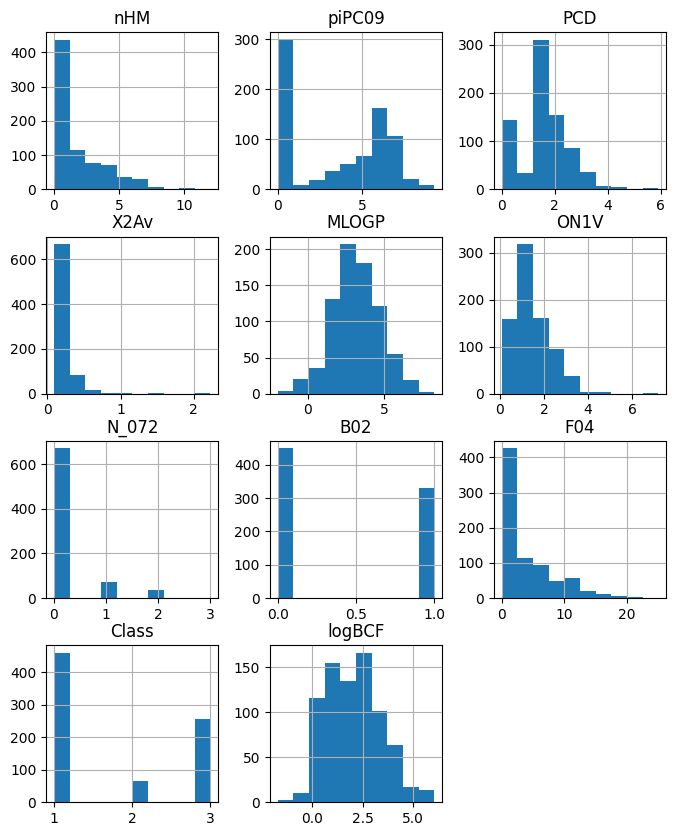

In [ ]:
df.hist(figsize=(8,10))

### Overview of the target variable


#### Distribution
We check whether the target variable (logBCF) follows a normal distribution, as the histogram shows some asymmetry.

Text(0.5, 1.0, 'Distribution of logBCF')

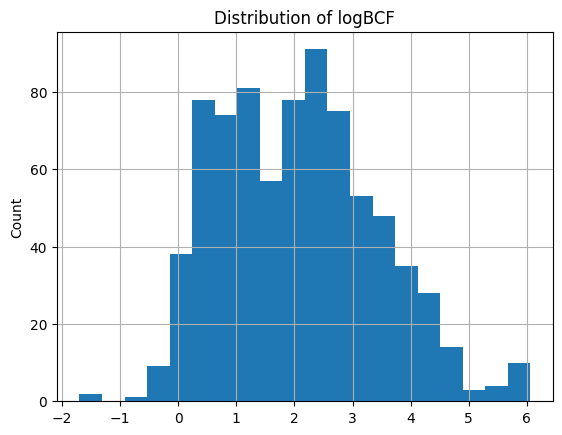

In [ ]:
df['logBCF'].hist(bins=20)
plt.ylabel("Count")
plt.title("Distribution of logBCF")

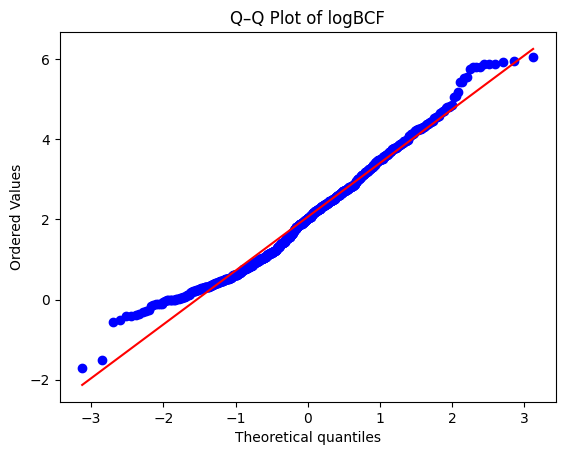

In [ ]:
# Q-Q plot
stats.probplot(df['logBCF'], dist = "norm", plot=plt)
plt.title("Q–Q Plot of logBCF")
plt.show()

The Q-Q plot shows that logBCF is approximately normally distributed, with some deviation at the tails.

#### Class level variability
We'll include an analysis of logBCF by chemical class.

In [ ]:
df_copy = df.copy()
df_copy["Class"] = df_class
df_copy.groupby('Class')['logBCF'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,460.0,2.053870,1.289870,-0.30,0.9300,2.015,2.9725,5.08
2,64.0,3.362969,1.692364,0.76,1.8975,3.450,4.8175,6.06
3,255.0,1.752510,1.163305,-1.70,0.8500,1.800,2.6650,4.13


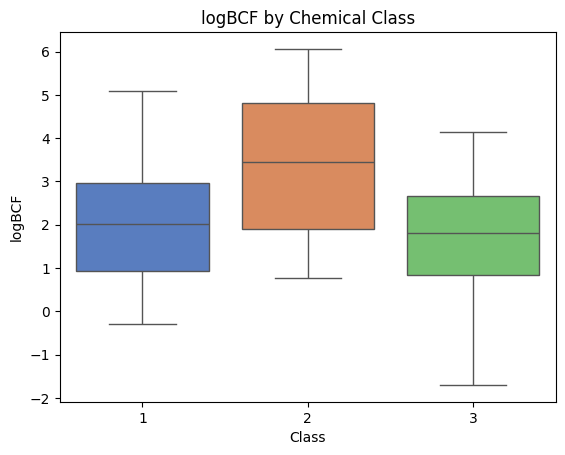

In [ ]:
ax = sns.boxplot(data=df_copy, x='Class', y='logBCF', hue = "Class", palette = "muted")
plt.title("logBCF by Chemical Class")
ax.legend().remove()
plt.show()

Visually, there appear to be differences among the classes. While the differences are not large, this suggests that class membership has some influence on bioconcentration. This will be addressed within the Hierarchical Model.

### Correlation

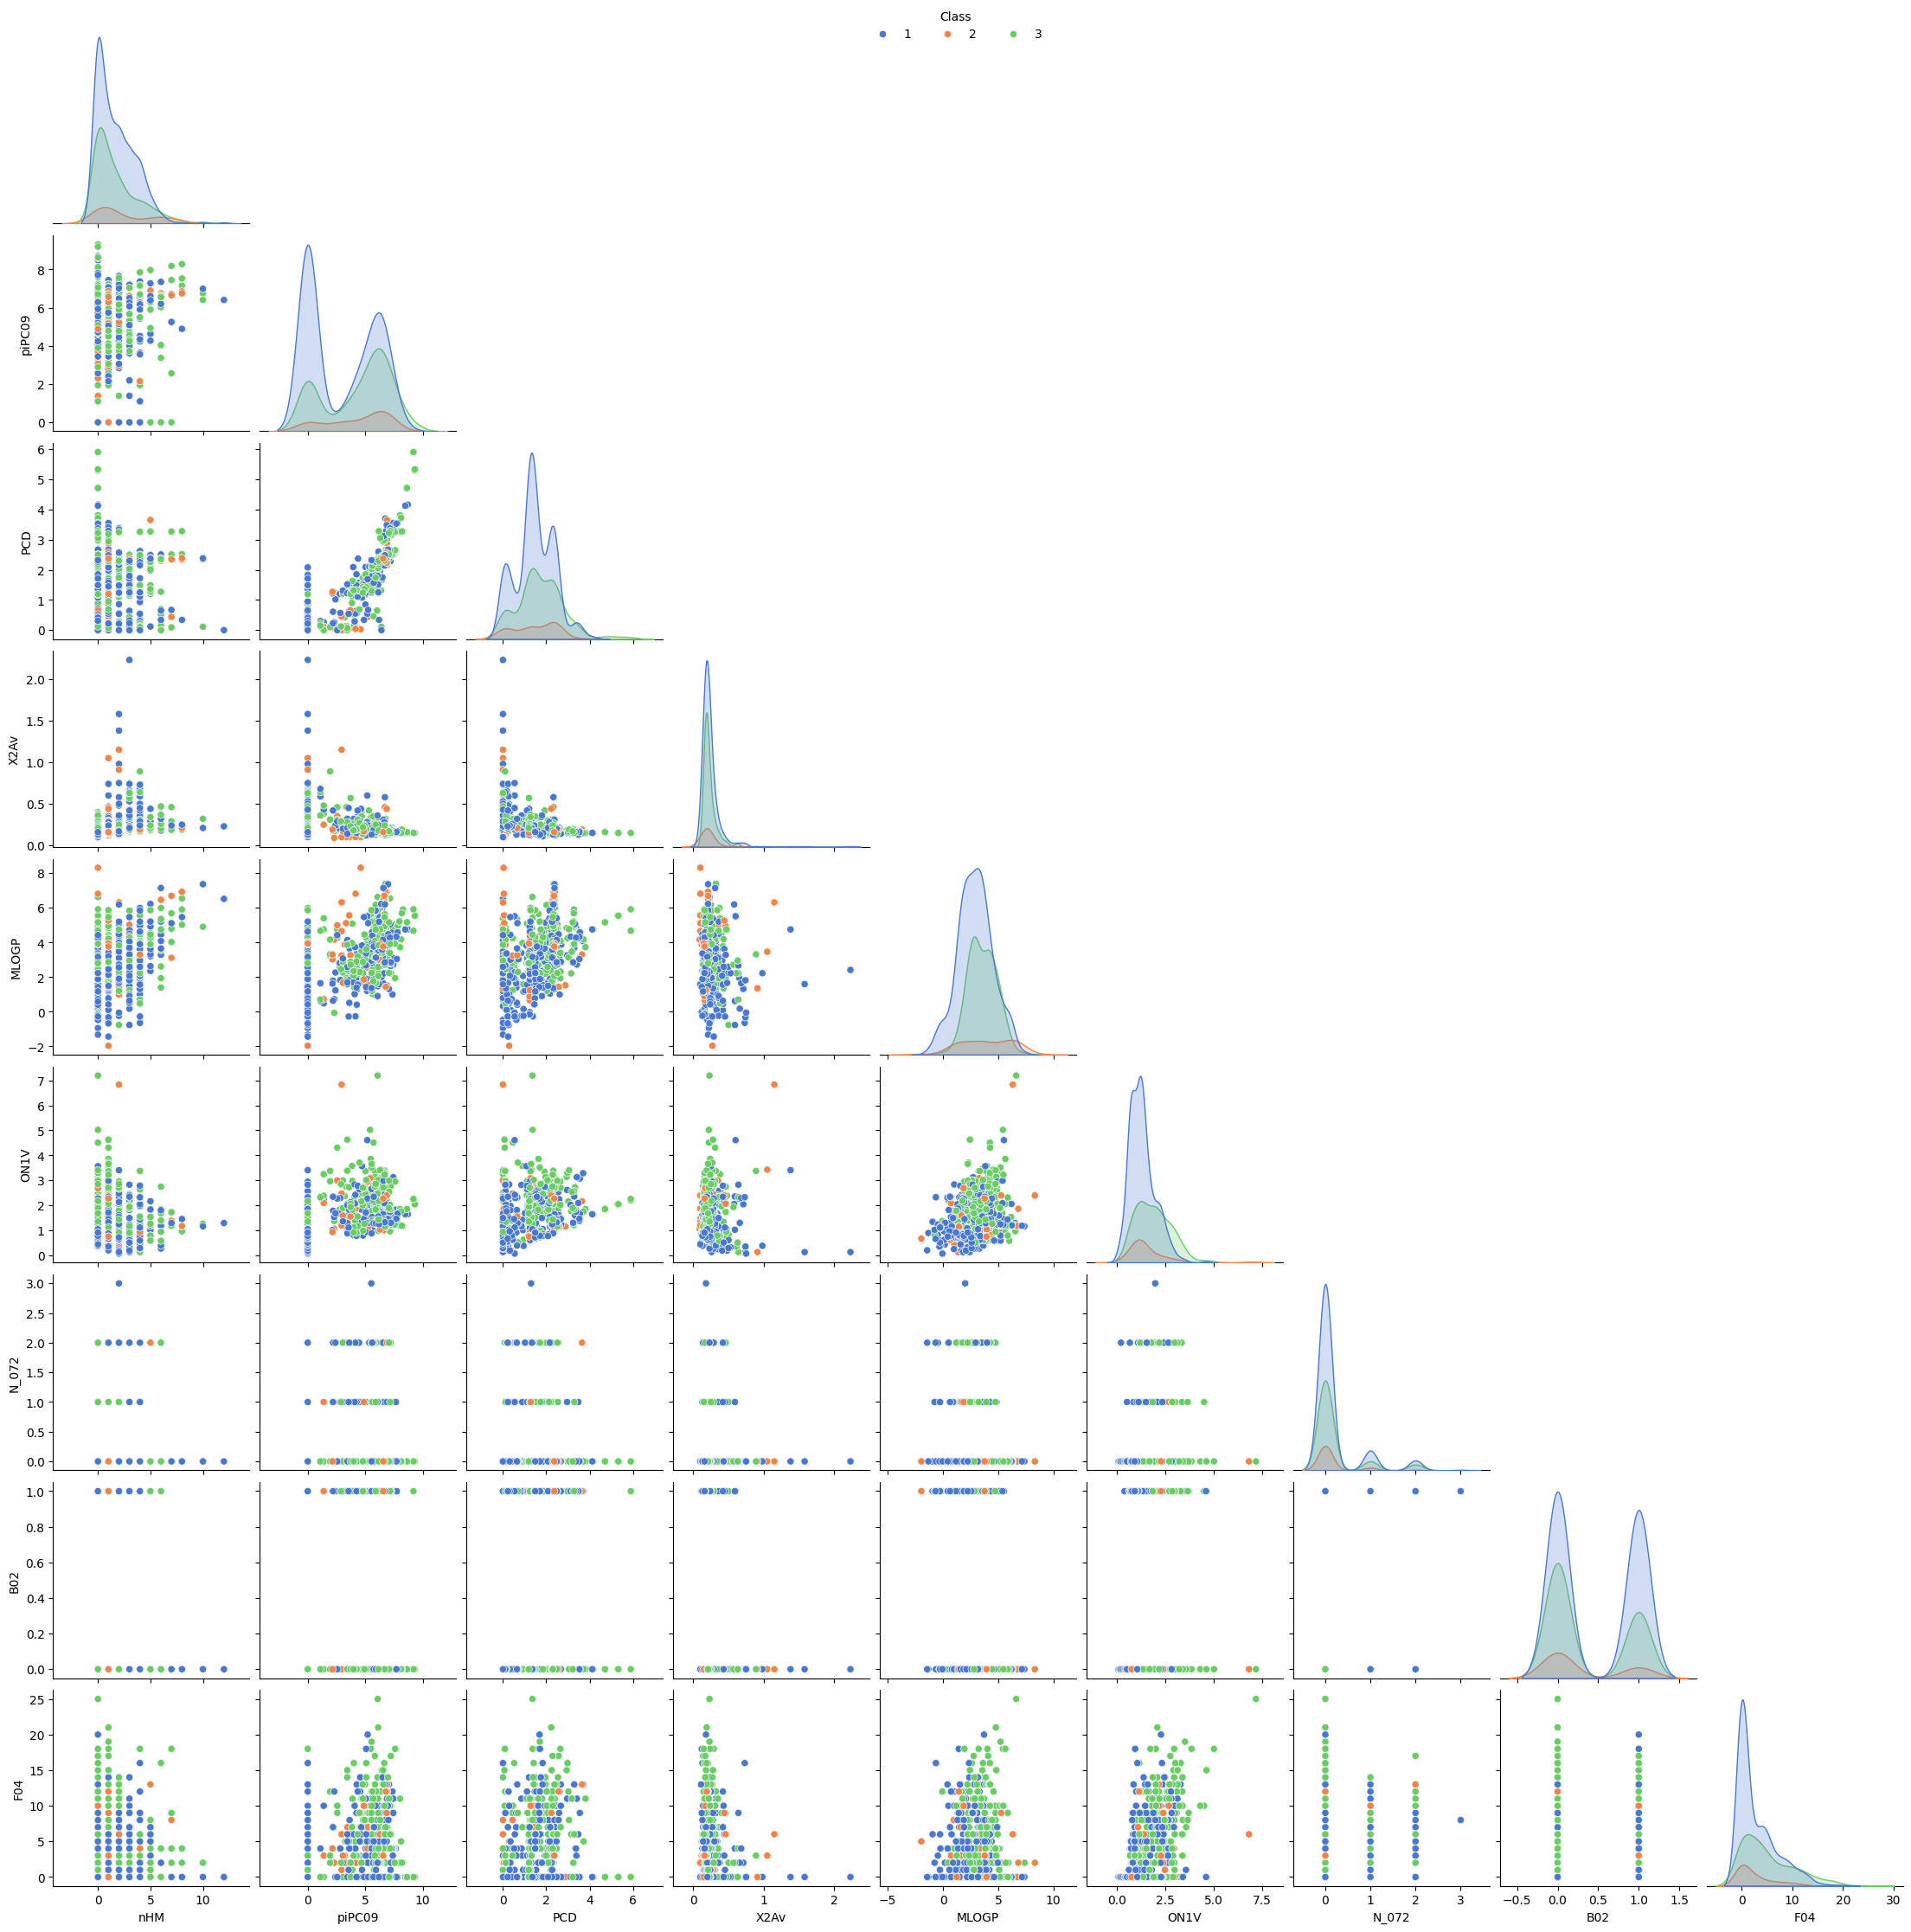

In [ ]:
ax = sns.pairplot(df.drop(columns = "logBCF"), hue = "Class", palette = "muted", corner = True)
sns.move_legend(ax, "upper center", ncol=3, title="Class")
plt.show()

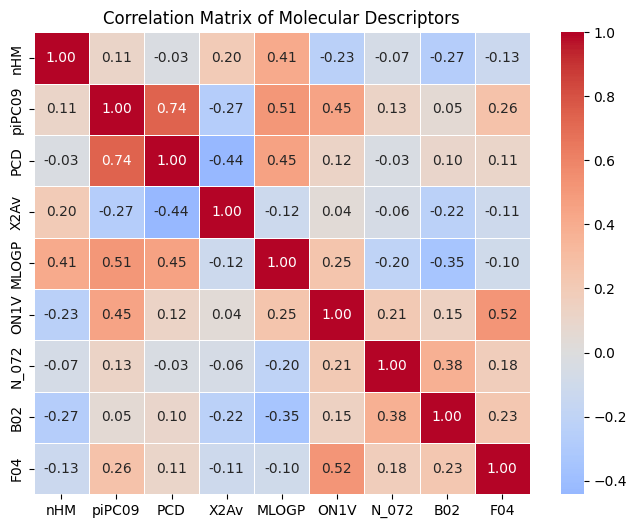

In [ ]:
corr = df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr,annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,center=0)
plt.title("Correlation Matrix of Molecular Descriptors")
plt.show()

From the correlation matrix there seems to be some multicollinearity among molecular descriptors, for example PCD and piPC09 are strongly correlated (r = 0.74). When predictors are highly correlated, the regression model struggles to determine how much each predictor independently contributes to the target. To address this we'll employ Ridge regression.

# Models



#### Model 1: Ridge Regression

The first model that we wanted to apply to explore the relationship between the molecular descriptors and the BCF is Ridge Regression, a shrinkage method that regularizes coefficient estimates to reduce variance and mitigate multicollinearity, typically at the cost of only a small increase in bias [4].

The Ridge regression coefficient estimates $\hat\beta ^R$ are the values that minimize:
$$RSS + \alpha\sum_{j=1}^p\beta _j^2$$

##### Cross-validation
We perform cross-validation across a grid of $\alpha$ values to identify the best tuning parameter for both the original and new dataset splits.

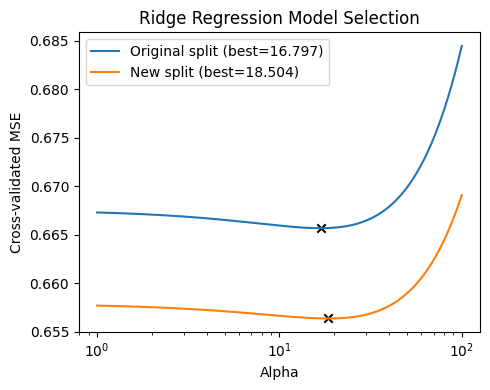

Original split: Best alpha = np.round(16.7967, 1), MSE = np.round(0.6657, 1)
New split: Best alpha = np.round(18.5041, 1), MSE = np.round(0.6564, 1)


In [ ]:
alphas = np.logspace(0, 2, 1000)
datasets = [
    ("Original split", x_train_scaled_orig.drop(columns = "Class"), y_train),
    ("New split", x_train_scaled_new.drop(columns = "Class"), y_train_new)
]

results = {}

plt.figure(figsize=(5, 4))
for label, X, y in datasets:
    mse_scores = [
        -cross_val_score(Ridge(alpha=a), X, y, cv=5,
                         scoring="neg_mean_squared_error").mean()
        for a in alphas
    ]
    best_alpha = alphas[np.argmin(mse_scores)]
    best_mse = np.min(mse_scores)
    results[label] = (best_alpha, best_mse)
    plt.plot(alphas, mse_scores, label=f"{label} (best={best_alpha:.3f})")
    plt.scatter(best_alpha, best_mse, marker="x", color="black")

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Cross-validated MSE")
plt.title("Ridge Regression Model Selection")
plt.legend()
plt.tight_layout()
plt.show()

for label, (a, mse) in results.items():
    print(f"{label}: Best alpha = np.round({a:.4f}, 1), MSE = np.round({mse:.4f}, 1)")

##### Train and Test

In [ ]:
ridge_orig = Ridge(alpha=results["Original split"][0])
ridge_new  = Ridge(alpha=results["New split"][0])

"""
#saving the model
joblib.dump(ridge_orig, 'ridge_orig.pkl')
joblib.dump(ridge_new, 'ridge_new.pkl')
files.download('ridge_orig.pkl')
files.download('ridge_new.pkl')
"""

#ridge_orig = joblib.load('/content/drive/MyDrive/Colab Notebooks/BERN02: Reproducible Project/ridge_orig.pkl')
#ridge_new = joblib.load('/content/drive/MyDrive/Colab Notebooks/BERN02: Reproducible Project/ridge_new.pkl')

"\n#saving the model\njoblib.dump(ridge_orig, 'ridge_orig.pkl')\njoblib.dump(ridge_new, 'ridge_new.pkl')\nfiles.download('ridge_orig.pkl')\nfiles.download('ridge_new.pkl')\n"

In [ ]:
ridge_orig.fit(x_train_scaled_orig.drop(columns = "Class"), y_train)
ridge_new.fit(x_train_scaled_new.drop(columns = "Class"), y_train_new)

Ridge(alpha=np.float64(18.504070195423022))

In [ ]:
y_pred_orig_train = ridge_orig.predict(x_train_scaled_orig.drop(columns = "Class"))
y_pred_orig_test = ridge_orig.predict(x_test_scaled_orig.drop(columns = "Class"))

y_pred_new_train = ridge_new.predict(x_train_scaled_new.drop(columns = "Class"))
y_pred_new_test = ridge_new.predict(x_test_scaled_new.drop(columns = "Class"))

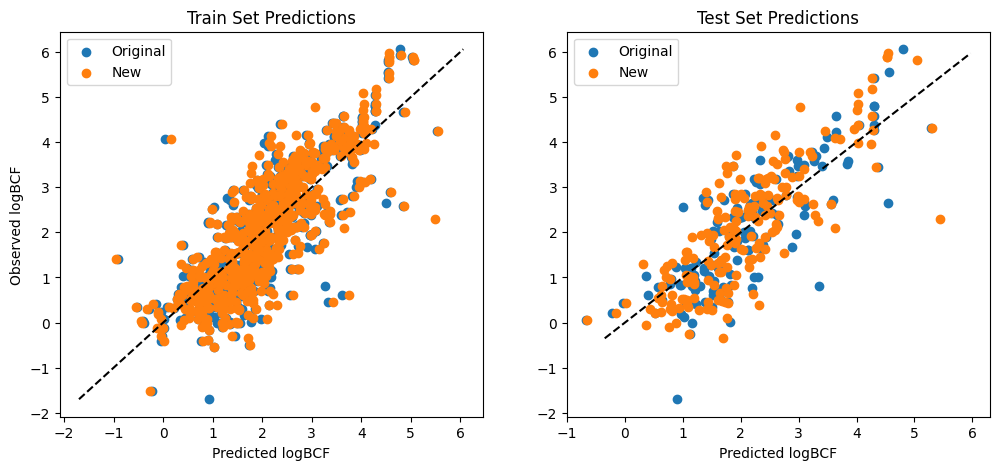

In [ ]:
fig, ax = plt.subplots(1, 2,figsize = (12, 5))
ax[0].scatter(y_pred_orig_train, y_train)
ax[0].scatter(y_pred_new_train, y_train_new)
ax[0].legend(["Original", "New"])
ax[0].set_title("Train Set Predictions")
ax[0].set_xlabel("Predicted logBCF")
ax[0].set_ylabel("Observed logBCF")
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="black", linestyle="--")

ax[1].scatter(y_pred_new_test, y_test_new)
ax[1].scatter(y_pred_orig_test, y_test)
ax[1].legend(["Original", "New"])
ax[1].set_title("Test Set Predictions")
ax[1].set_xlabel("Predicted logBCF")
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--")
plt.show()

##### Feature Importance

In [ ]:
feature_original = pd.DataFrame(
    {'coefficients':ridge_orig.coef_},
    index=x_test_scaled_orig.drop(columns = "Class").columns)
feature_imp_original = feature_original.sort_values(by="coefficients", ascending=False)
feature_imp_original

,coefficients
MLOGP,0.760647
nHM,0.273268
piPC09,0.132573
ON1V,0.102191
PCD,0.035201
X2Av,-0.018479
N_072,-0.062204
B02,-0.068468
F04,-0.152062


In [ ]:
feature_new = pd.DataFrame(
    {'coefficients':ridge_new.coef_},
    index=x_test_scaled_new.drop(columns = "Class").columns)
feature_imp_new = feature_new.sort_values(by="coefficients", ascending=False)
feature_imp_new

,coefficients
MLOGP,0.776176
nHM,0.267482
piPC09,0.122316
ON1V,0.080824
PCD,0.042425
X2Av,-0.003038
N_072,-0.059531
B02,-0.091125
F04,-0.107151


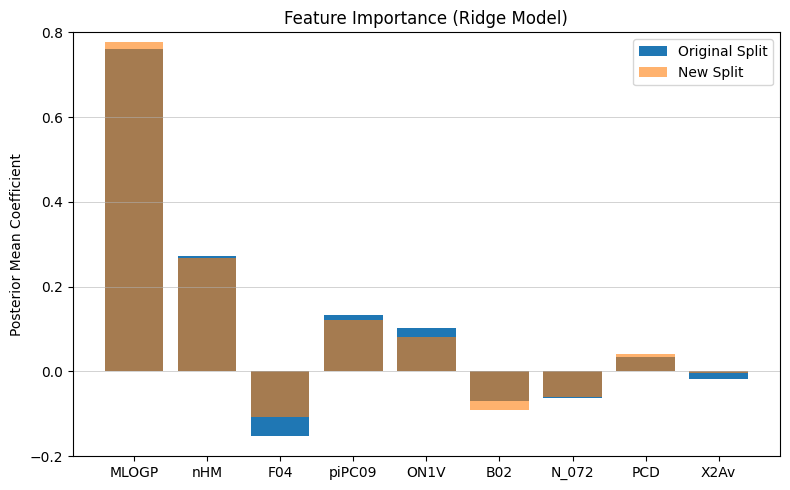

In [ ]:
fixed_effects_orig = feature_imp_original['coefficients']
fixed_effects_new = feature_imp_new['coefficients']

sorted_idx = fixed_effects_orig.abs().sort_values(ascending=False).index

plt.figure(figsize=(8, 5))
plt.bar(sorted_idx, fixed_effects_orig[sorted_idx],label="Original Split")
plt.bar(sorted_idx, fixed_effects_new[sorted_idx],label="New Split", alpha=0.6)
plt.ylabel("Posterior Mean Coefficient")
plt.title("Feature Importance (Ridge Model)")
plt.legend()
plt.grid(linewidth = 0.4, axis = "y")
plt.ylim(-0.2, 0.8)
plt.tight_layout()
plt.show()

For both of the data splits feature importance analysis provided the same ranking of molecular descriptors by their absolute coefficient values, so the importance of the descriptors is not influenced by the choice of training/testing partition.

* MLOGP is the most influential descriptor indicating that more lipophilic compounds tend to show higher BFC;
* both nHM and ON1V have moderate effects suggesting that compounds with more hydrogen-bond donor sites tend to have slightly higher logBCF.

##### Performance Metrics

In [ ]:
# RMSE original, train
RMSE_ridge_orig_train = root_mean_squared_error(y_true= y_train, y_pred=y_pred_orig_train)
r2_ridge_orig_train = r2_score(y_train,y_pred_orig_train)

# RMSE new, train
RMSE_ridge_new_train = root_mean_squared_error(y_true= y_train_new, y_pred=y_pred_new_train)
r2_ridge_new_train = r2_score(y_train_new,y_pred_new_train)

# RMSE orignal, test
RMSE_ridge_orig_test = root_mean_squared_error(y_true= y_test, y_pred=y_pred_orig_test)
r2_ridge_orig_test = r2_score(y_test,y_pred_orig_test)


# RMSE new, test
RMSE_ridge_new_test = root_mean_squared_error(y_true= y_test_new, y_pred=y_pred_new_test)
r2_ridge_new_test = r2_score(y_test_new,y_pred_new_test)


ridge_results = pd.DataFrame({
    "Dataset": ["Train", "Train", "Test", "Test"],
    "Split": ["Original", "New", "Original", "New"],
    "RMSE": [RMSE_ridge_orig_train,RMSE_ridge_new_train,RMSE_ridge_orig_test,RMSE_ridge_new_test],
    "R2": [r2_ridge_orig_train,r2_ridge_new_train,r2_ridge_orig_test,r2_ridge_new_test]
})
display(ridge_results)

,Dataset,Split,RMSE,R2
0,Train,Original,0.776956,0.661145
1,Train,New,0.793627,0.656867
2,Test,Original,0.810274,0.662159
3,Test,New,0.746136,0.686318


From the model performance we can say that:
* The model is not overfitted as the similarity between training and testing performance suggests;
* The model’s predictive ability is not sensitive to the particular way the data is partitioned because comparing the two data splits shows consistent results.

While the Ridge model effectively handles multicollinearity, it treats all data points as independent and so assumes that all molecular descriptors influence the BCF in the same way across all classes. Compounds with different bioaccumulation potentials may exhibit different descriptor-BCF relationships.

To capture this possible variability, we implementeed a hierarchical model, with Class treated as a group-level factor.

#### Model 2: Hierarchal
We fit a Hierarchical linear model of the form:
$$logBCF_{ij}=\beta_0+\sum_{k=1}^9\beta _kX_{k,ij}+u_{0j}+ε_{ij}$$
Where:
* i are the individual molecules and j are the bioaccumulation classes
* $X_{k,ij}$ is the molecular descriptor k for compound i in class j
* $u_{0j} \sim N(0,\tau^2)$ random effect for the class
* $ε_{ij}\sim N(0,\sigma^2)$ residual error


In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "1|Class": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1))
}

hierarical_model_original = bmb.Model("logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V	+ N_072 + B02 +	F04 + (1|Class)", data_train, priors=priors)
display(hierarical_model_original)

hierarical_model_new = bmb.Model("logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V  + N_072 + B02 +	F04 + (1|Class)", data_train_new, priors=priors)
display(hierarical_model_new)

       Formula: logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V	+ N_072 + B02 +	F04 + (1|Class)
        Family: gaussian
          Link: mu = identity
  Observations: 584
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            nHM ~ Normal(mu: 0.0, sigma: 3.3368)
            piPC09 ~ Normal(mu: 0.0, sigma: 3.3368)
            PCD ~ Normal(mu: 0.0, sigma: 3.3368)
            X2Av ~ Normal(mu: 0.0, sigma: 3.3368)
            MLOGP ~ Normal(mu: 0.0, sigma: 3.3368)
            ON1V ~ Normal(mu: 0.0, sigma: 3.3368)
            N_072 ~ Normal(mu: 0.0, sigma: 3.3368)
            B02 ~ Normal(mu: 0.0, sigma: 3.3368)
            F04 ~ Normal(mu: 0.0, sigma: 3.3368)
        
        Group-level effects
            1|Class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3347)

       Formula: logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V  + N_072 + B02 +	F04 + (1|Class)
        Family: gaussian
          Link: mu = identity
  Observations: 623
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            nHM ~ Normal(mu: 0.0, sigma: 3.3871)
            piPC09 ~ Normal(mu: 0.0, sigma: 3.3871)
            PCD ~ Normal(mu: 0.0, sigma: 3.3871)
            X2Av ~ Normal(mu: 0.0, sigma: 3.3871)
            MLOGP ~ Normal(mu: 0.0, sigma: 3.3871)
            ON1V ~ Normal(mu: 0.0, sigma: 3.3871)
            N_072 ~ Normal(mu: 0.0, sigma: 3.3871)
            B02 ~ Normal(mu: 0.0, sigma: 3.3871)
            F04 ~ Normal(mu: 0.0, sigma: 3.3871)
        
        Group-level effects
            1|Class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3548)

In [ ]:
if 1:
  # Original data split
  result_original = hierarical_model_original.fit(draws = 1500, tune = 1000, target_accept = 0.95)

  # Our data split
  result_new = hierarical_model_new.fit(draws = 1500, tune = 1000, target_accept = 0.95)

Output()

Output()

The priors assigned by default by Bambi are weakly informative, we reported some divergences, so we swapped the default priors with tighter ones.

In [ ]:
# trying tighter priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "1|Class": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
            "nHM": bmb.Prior("Normal", mu=0, sigma=1),
            "piPC09": bmb.Prior("Normal", mu=0, sigma=1),
            "PCD": bmb.Prior("Normal", mu=0, sigma=1),
            "X2Av": bmb.Prior("Normal", mu=0, sigma=1),
            "MLOGP": bmb.Prior("Normal", mu=0, sigma=1),
            "ON1V": bmb.Prior("Normal", mu=0, sigma=1),
            "N_072": bmb.Prior("Normal", mu=0, sigma=1),
            "B02": bmb.Prior("Normal", mu=0, sigma=1),
            "F04": bmb.Prior("Normal", mu=0, sigma=1)
}
#predictors = df.drop(columns=["Set", "Class", "logBCF"])
hierarical_model_original = bmb.Model("logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V	+ N_072 + B02 +	F04 + (1|Class)", data_train, priors=priors)
display(hierarical_model_original)

hierarical_model_new = bmb.Model("logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V  + N_072 + B02 +	F04 + (1|Class)", data_train_new, priors=priors)
display(hierarical_model_new)

       Formula: logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V	+ N_072 + B02 +	F04 + (1|Class)
        Family: gaussian
          Link: mu = identity
  Observations: 584
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            nHM ~ Normal(mu: 0.0, sigma: 1.0)
            piPC09 ~ Normal(mu: 0.0, sigma: 1.0)
            PCD ~ Normal(mu: 0.0, sigma: 1.0)
            X2Av ~ Normal(mu: 0.0, sigma: 1.0)
            MLOGP ~ Normal(mu: 0.0, sigma: 1.0)
            ON1V ~ Normal(mu: 0.0, sigma: 1.0)
            N_072 ~ Normal(mu: 0.0, sigma: 1.0)
            B02 ~ Normal(mu: 0.0, sigma: 1.0)
            F04 ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|Class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3347)

       Formula: logBCF ~ nHM +	piPC09 + PCD	+ X2Av	+ MLOGP +	ON1V  + N_072 + B02 +	F04 + (1|Class)
        Family: gaussian
          Link: mu = identity
  Observations: 623
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            nHM ~ Normal(mu: 0.0, sigma: 1.0)
            piPC09 ~ Normal(mu: 0.0, sigma: 1.0)
            PCD ~ Normal(mu: 0.0, sigma: 1.0)
            X2Av ~ Normal(mu: 0.0, sigma: 1.0)
            MLOGP ~ Normal(mu: 0.0, sigma: 1.0)
            ON1V ~ Normal(mu: 0.0, sigma: 1.0)
            N_072 ~ Normal(mu: 0.0, sigma: 1.0)
            B02 ~ Normal(mu: 0.0, sigma: 1.0)
            F04 ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|Class ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.3548)

In [ ]:
if 1:
  # Original data split
  result_original = hierarical_model_original.fit(draws = 1500, tune = 1000, target_accept = 0.95)

  # Our data split
  result_new = hierarical_model_new.fit(draws = 1500, tune = 1000, target_accept = 0.95)

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


With these priors, the model fit stabilized.

In [ ]:
# plot priors original
if 0:
  hierarical_model_original.plot_priors()

In [ ]:
# plot priors our
if 0:
  hierarical_model_new.plot_priors()

In [ ]:
#saving the fit results
"""
joblib.dump(result_original, 'result_orig.pkl')
joblib.dump(result_new, 'result_new.pkl')
files.download('result_orig.pkl')
files.download('result_new.pkl')
"""
result_original = joblib.load('/content/drive/MyDrive/Colab Notebooks/BERN02: Reproducible Project/result_orig.pkl')
result_new = joblib.load('/content/drive/MyDrive/Colab Notebooks/BERN02: Reproducible Project/result_new.pkl')

In [ ]:
# original summary and graph
summary_original = az.summary(result_original, hdi_prob = 0.95)
print(summary_original)
#hierarical_model_original.graph()
mean_orig_train = summary_original['mean']

                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
1|Class[1]     0.614  0.606    -0.402      1.924      0.020    0.014   
1|Class[2]     1.202  0.610     0.124      2.452      0.020    0.014   
1|Class[3]    -0.193  0.605    -1.272      1.073      0.020    0.014   
1|Class_sigma  1.001  0.461     0.320      1.925      0.013    0.012   
B02           -0.118  0.035    -0.187     -0.055      0.001    0.001   
F04           -0.095  0.035    -0.165     -0.028      0.001    0.001   
Intercept      1.639  0.605     0.275      2.610      0.020    0.014   
MLOGP          0.747  0.047     0.655      0.840      0.001    0.001   
N_072         -0.074  0.031    -0.135     -0.012      0.001    0.001   
ON1V           0.261  0.050     0.164      0.359      0.001    0.001   
PCD            0.165  0.053     0.066      0.270      0.001    0.001   
X2Av          -0.009  0.034    -0.073      0.056      0.001    0.001   
nHM            0.314  0.038     0.238      0.385      0.001    0

In [ ]:
# Our summary and graph
summary_new = az.summary(result_new, hdi_prob = 0.95)
print(summary_new)
#hierarical_model_new.graph()
mean_new_train = summary_new['mean']

                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
1|Class[1]     0.620  0.597    -0.318      1.964      0.022    0.021   
1|Class[2]     1.166  0.602     0.151      2.418      0.022    0.021   
1|Class[3]    -0.207  0.595    -1.196      1.046      0.022    0.021   
1|Class_sigma  0.998  0.458     0.322      1.898      0.014    0.013   
B02           -0.153  0.035    -0.223     -0.085      0.001    0.001   
F04           -0.055  0.036    -0.123      0.015      0.001    0.001   
Intercept      1.652  0.595     0.322      2.587      0.022    0.021   
MLOGP          0.790  0.046     0.697      0.878      0.001    0.001   
N_072         -0.055  0.032    -0.117      0.005      0.001    0.001   
ON1V           0.195  0.047     0.108      0.293      0.001    0.001   
PCD            0.125  0.053     0.024      0.231      0.001    0.001   
X2Av          -0.012  0.031    -0.073      0.049      0.001    0.001   
nHM            0.281  0.038     0.206      0.354      0.001    0

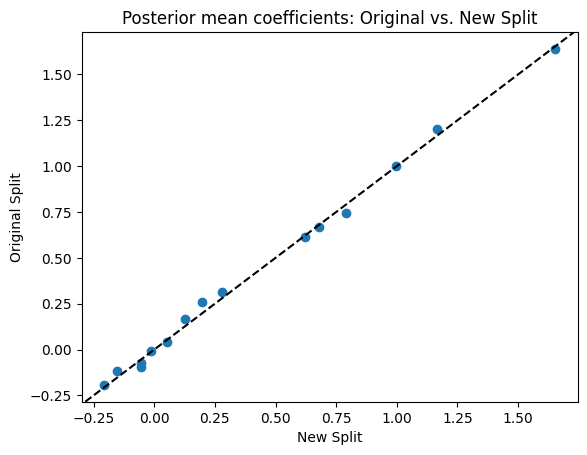

In [ ]:
# plotting prior means
plt.scatter(mean_new_train, mean_orig_train)
plt.axline([0, 0], [1, 1], color="black", linestyle="--")
plt.title("Posterior mean coefficients: Original vs. New Split")
plt.xlabel("New Split")
plt.ylabel("Original Split")
plt.show()


The hierarchical model generalizes well across different training/testing partitions meaning that the estimated descriptor effects are not highly sensitive to the data split.

##### Train and test

In [ ]:
# train original predictions
resp_orig_pred = hierarical_model_original.predict(data  = x_train_scaled_orig, idata = result_original, kind = "response_params", inplace = False)
resp_orig_pred_new = hierarical_model_original.predict(data = x_train_scaled_new, idata = result_original, kind = "response_params", inplace = False)

In [ ]:
# train new predictions
resp_new_pred = hierarical_model_new.predict(data = x_train_scaled_new, idata = result_new,kind = "response_params",  inplace = False)
resp_new_pred_orig = hierarical_model_new.predict(data = x_train_scaled_orig, idata = result_new,kind = "response_params",  inplace = False)

In [ ]:
# TRAIN
## Original
y_orig_pred = resp_orig_pred.posterior["mu"].mean(dim = ["chain", "draw"]).values
## New
y_new_pred = resp_new_pred.posterior["mu"].mean(dim = ["chain", "draw"]).values


In [ ]:
# test original predictions (The OGs)
resp_orig_pred_test = hierarical_model_original.predict(data  = x_test_scaled_orig, idata = result_original, kind = "response_params", inplace = False)
resp_orig_pred_new_test = hierarical_model_original.predict(data = x_test_scaled_new, idata = result_original, kind = "response_params", inplace = False)

In [ ]:
# test new predictions
resp_new_pred_test = hierarical_model_new.predict(data = x_test_scaled_new, idata = result_new,kind = "response_params",  inplace = False)
resp_new_pred_orig_test = hierarical_model_new.predict(data = x_test_scaled_orig, idata = result_new,kind = "response_params",  inplace = False)

In [ ]:
#TEST
## Original
y_orig_pred_test = resp_orig_pred_test.posterior["mu"].mean(dim = ["chain", "draw"]).values
## New
y_new_pred_test = resp_new_pred_test.posterior["mu"].mean(dim = ["chain", "draw"]).values


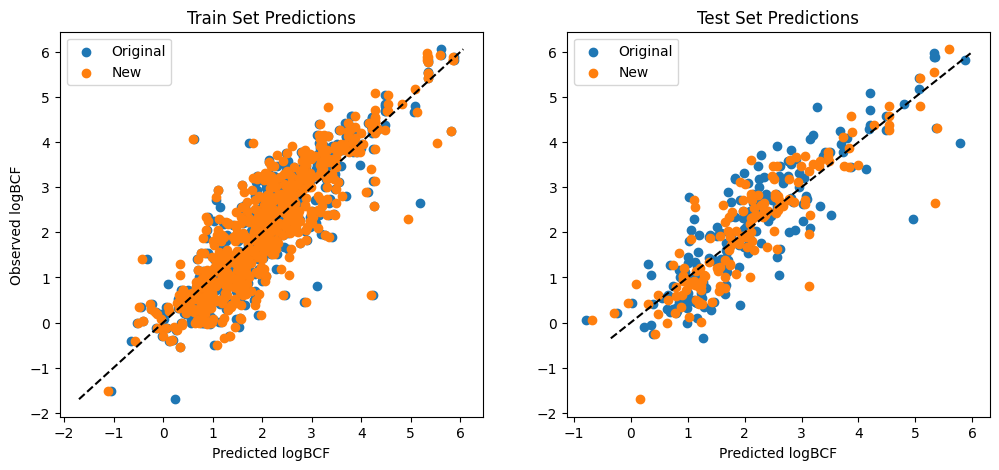

In [ ]:
fig, ax = plt.subplots(1, 2,figsize = (12, 5))
ax[0].scatter(y_orig_pred, y_train)
ax[0].scatter(y_new_pred, y_train_new)
ax[0].legend(["Original", "New"])
ax[0].set_title("Train Set Predictions")
ax[0].set_xlabel("Predicted logBCF")
ax[0].set_ylabel("Observed logBCF")
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="black", linestyle="--")

ax[1].scatter(y_orig_pred_test, y_test)
ax[1].scatter(y_new_pred_test, y_test_new)
ax[1].legend(["Original", "New"])
ax[1].set_title("Test Set Predictions")
ax[1].set_xlabel("Predicted logBCF")
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--")
plt.show()

##### Performance metrics



In [ ]:
err_orig_train = root_mean_squared_error(y_train,y_orig_pred)
err_new_train = root_mean_squared_error(y_train_new,y_new_pred)

r2_score_orig_train = r2_score(y_train,y_orig_pred)
r2_score_new_train = r2_score(y_train_new,y_new_pred)

print(f"Root mean square error for the original split {np.round(err_orig_train, 2)}")
print(f"Root mean square error for the new split {np.round(err_new_train, 2)}")
print(f"R2 for the originak split {np.round(r2_score_orig_train, 2)}")
print(f"R2 for the new split {np.round(r2_score_new_train, 2)}")

Root mean square error for the original split 0.66
Root mean square error for the new split 0.67
R2 for the originak split 0.76
R2 for the new split 0.75


In [ ]:
err_orig_test = root_mean_squared_error(y_test,y_orig_pred_test)
err_new_test = root_mean_squared_error(y_test_new,y_new_pred_test)
r2_score_orig_test = r2_score(y_test,y_orig_pred_test)
r2_score_new_test = r2_score(y_test_new,y_new_pred_test)

print(f"Root mean square error for the original split {np.round(err_orig_test, 2)}")
print(f"Root mean square error for the new split {np.round(err_new_test, 2)}")
print(f"R2 for the originak split {np.round(r2_score_orig_test, 2)}")
print(f"R2 for the new split {np.round(r2_score_new_test, 2)}")


Root mean square error for the original split 0.68
Root mean square error for the new split 0.63
R2 for the originak split 0.77
R2 for the new split 0.78


In [ ]:
performance = pd.DataFrame({
    "Model Type": ["Ridge Regression", "Ridge Regression", "Hierarchical Model", "Hierarchical Model"],
    "Data Split": ["Original Split", "New Split", "Original Split", "New Split"],
    "RMSE (Train)": [RMSE_ridge_orig_train,RMSE_ridge_new_train, err_orig_train, err_new_train],
    "R2 (Train)": [r2_ridge_orig_train,r2_ridge_new_train, r2_score_orig_train, r2_score_new_train],
    "RMSE (Test)": [RMSE_ridge_orig_test,RMSE_ridge_new_test, err_orig_test, err_new_test],
    "R2 (Test)": [r2_ridge_orig_test,r2_ridge_new_test, r2_score_orig_test, r2_score_new_test]})
display(performance)

,Model Type,Data Split,RMSE (Train),R2 (Train),RMSE (Test),R2 (Test)
0,Ridge Regression,Original Split,0.776956,0.661145,0.810274,0.662159
1,Ridge Regression,New Split,0.793627,0.656867,0.746136,0.686318
2,Hierarchical Model,Original Split,0.659798,0.755633,0.675409,0.765263
3,Hierarchical Model,New Split,0.671909,0.754048,0.625540,0.779523


The hierarchical model achieves lower RMSE and higher R2 values than ridge regression for both training and testing datasets.

##### Feature Importance

In [ ]:
sum_abs = np.abs(summary_original['mean']).sort_values(ascending = False)
display(sum_abs)

,mean
Intercept,1.639
1|Class[2],1.202
1|Class_sigma,1.001
MLOGP,0.747
sigma,0.668
1|Class[1],0.614
nHM,0.314
ON1V,0.261
1|Class[3],0.193
PCD,0.165


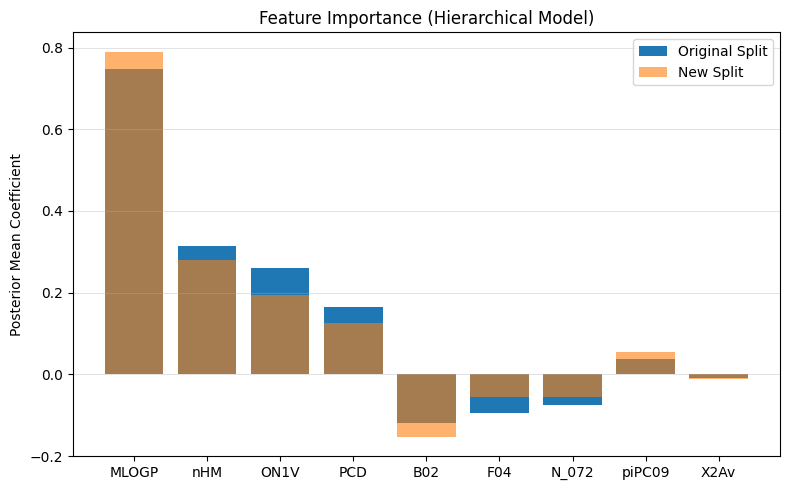

In [ ]:
# removing intercepts, group-level and residual error
fixed_effects_orig = mean_orig_train[~mean_orig_train.index.str.contains("Intercept|Class|sigma")]
fixed_effects_new = mean_new_train[~mean_new_train.index.str.contains("Intercept|Class|sigma")]

sorted_idx = fixed_effects_orig.abs().sort_values(ascending=False).index

plt.figure(figsize=(8, 5))
plt.bar(sorted_idx, fixed_effects_orig[sorted_idx],label="Original Split")
plt.bar(sorted_idx, fixed_effects_new[sorted_idx],label="New Split", alpha=0.6)
plt.ylabel("Posterior Mean Coefficient")
plt.title("Feature Importance (Hierarchical Model)")
plt.legend()
plt.grid(linewidth = 0.5, alpha = 0.5, axis = "y")
plt.tight_layout()
plt.show()

The most important features resulted being the same ones found for ridge regression.

## FAIR-principle

The FAIR principle refrences a concept in which the data and workflow is for the data to be findable and usable by machines and to be reused by humans [5]. It was therefore import as part of this project to follow this principle to the furthest extent possible, how each part of the principle is seen in the project will be discussed below.

Reflection on FAIR principles, and how each concept of the acronym relates to the project (data and workflow).

### **Findable**
The project is findable because of the usage of GitHub, a public repository, keywords that represent the project, a link to the data in the workflow which enables others to find the data that was used. In addition, within the workflow the data is described in great detail.

### **Accessible**
The project is accessible as the data has been given accessibiliy by referencing it in the workflow. The projects worflow will also continue to exist even without the existence of the data. The workflow is open, free and universally implementable by being published in an open GitHub repository and by stating the version of the packages as well as using readily available packages it is universally implementable. The data is open, free and universally implementable by being a open CSV file that is freely accesible.


### **Interoperable**
The data uses a CSV file format with is a formal, accessible, shared and brooadly applicable language. The metadata exists within a Notebook and uses Python as the coding language which is both formal and accessible. The metadata and data uses vocabularies that follow the FAIR principles by using english as the written language and by describing the features clearly. The project uses several qualified references to further emphasise and describe the data and metadata.


### **Reusable**
The project is extensively reusable due to the previously stated reasons in addition to having a clear and accessible license to show how the metadata and data is to be used and referenced.

# References
[1] W.-X. Wang, “Bioaccumulation and biomonitoring,” in Marine Ecotoxicology. Elsevier, 2016,
pp. 99-119. doi: 10.1016/B978-0-12-803371-5.00004-7.

[2] F. Grisoni, V. Consonni, S. Villa, M. Vighi, and R. Todeschini, “Qsar models for bioconcentra-
tion: Is the increase in the complexity justified by more accurate predictions?” Chemosphere,
vol. 127, pp. 171-179, May 2015, issn: 00456535. doi: 10.1016/j.chemosphere.2015.01.047.

[3] F. Grisoni, V. Consonni, M. Vighi, S. Villa, and R. Todeschini, “Investigating the mechanisms
of bioconcentration through qsar classification trees,” Environment International, vol. 88,
pp. 198-205, Mar. 2016, issn: 01604120. doi: 10.1016/j.envint.2015.12.024.

[4] J. Gareth, D. Witten, T. Hastie, R. Tibshirani, and J. Taylor, An introduction to statistical
learning: With applications in python. Springer International Publishing: Cham, Switzerland,
2023.

[5] Wilkinson, M., Dumontier, M., Aalbersberg, I. et al. (2016). The FAIR Guiding Principles for scientific data management and stewardship. Sci Data 3, 160018. https://doi.org/10.1038/sdata.2016.18

# License

                    GNU GENERAL PUBLIC LICENSE
                       Version 2, June 1991

 Copyright (C) 1989, 1991 Free Software Foundation, Inc.,
 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.